# Credit Fraud Detector 

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Introduction

In this tutorial we will use various predictive models to see how accurate they are in detecting whether a transaction
is a normal payment or fraud. As described in the dataset, the features are scaled and the names of the features 
are not shown due to privacy reasons. Nevertheless, we can still analyze some important aspects of the dataset

### Objective

1. Understand the little distribution of the "little" data that was provided to us.
2. Create a 50/50 sub-dataframe ratio of "Fraud" and "Non-Fraud" transactions (using NearMiss Algorithm).
3. Determine the Classifiers we are going to use and decide which one has higher accuracy.
4. Create a Neural Network and compare the accuracy to our best classifier.
5. Understand common mistakes made with imbalanced datasets.

### Outline:

1. Understanding the data
 - Gather Sense of our data
 
2. Proprocessing
 - Scaling and Distributing
 - Splitting the data
 
3. Random UnderSampling and OverSampling 
 - Distributing and Correlating
 - Anomaly Detection
 - Dimensionality Reduction and Clustering (t-SNE)
 - Classifiers
 - A deeper look into Logistic Regression
 - oversampling with SMOTE
 
4. Testing
 - Testing with Logistic Regression
 - Neural Networks Testing (UnderSampling vs OverSampling)
 
### Corrective Previous Mistakes from Imbalanced Datasets:
 
 1. Never test on the oversampled or undersampled dataset
 2. If we want to implement cross-validation, remember to oversample or undersample your training data during cross-validation , not before!
 3. Don't use **accuracy score** as a metric with imbalanced datasets (will be usually high and misleading), instead use **f1-score, precision/recall score or confusion matrix.**
 
### References:
 
 1. Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn by Coding-Maniac
 2. auprc, 5-fold c-v, and resampling methods by Jeremy Lane (Kaggle Notebook)

### Gather Sense of Our Data:

Except for the transaction and amount we don't know what the other columns  are (due to privacy reasons). The only thing we know, is that those columns that are unknown have been scaled already. 

#### Summary:

- The transaction amount is relatively small. The mean of all the amounts made is approximately USD 88. 
- There are no "null" values, so we dont have to work on ways to replace values.
- Most of the transactions were Non-Fraud (99.83%) of the time, while Fraud transactions occurs (0.017%) of the time in the dataframe.

#### Feature Technicalities:

- **PCA Transformation**: The description of the data says that all the features went through a PCA transformation (Dimensionality Reduction technique) (Except for the time and amount). 
- **Scaling**: In order to implement a PCA transformation features need to previously scaled. In this dataset, all the V features have been scaled or at least that is what we are assuming the people that develop the dataset did.

In [59]:
# Imported libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Other libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [60]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Projects/Credit Fraud Detection/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [61]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [62]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [63]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [64]:
# The classes are heavily skewed we need to solve this issue later. 
print('No Frauds', round(df['Class'].value_counts()[0]/len(df)*100, 2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df)*100, 2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are non-fraud. But we want to detect patterns that provide signs of fraudulent transactions

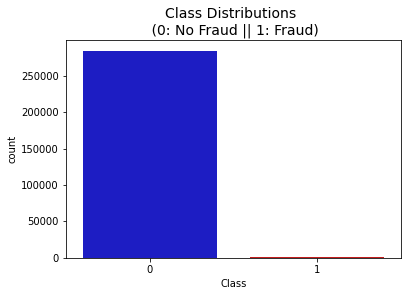

In [65]:
colors = ['#0101DF', '#DF0101']

sns.countplot('Class', data=df, palette = colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14);

**Distributions:** By seeing the ditributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed which will be implemented in this notebook.  

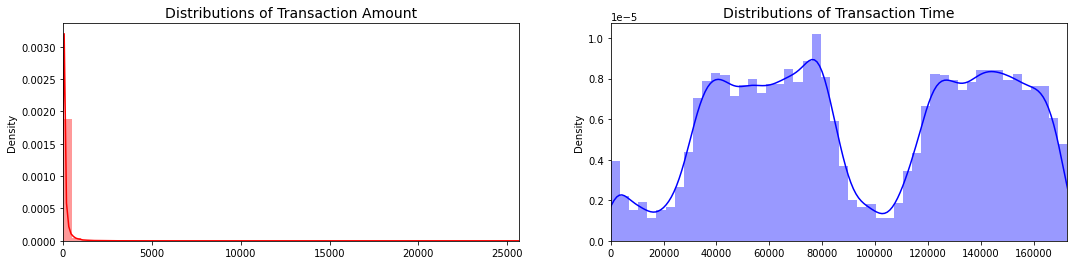

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distributions of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distributions of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

### Scaling and Distributing 

In this phase of this kernel, we first scale the columns comprise of Time and Amount. Time and amount should be scaled as the other columns. On the other hand, we need to also create a sub sample of the dataframe in order to have an equal amount of Fraud and Non Fraud cases, helping our algorithms better understand patterns that determine whether a transaction is a fraud or not. 

#### What is a sub sample?
In this scenario, our subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub sample will have the amount of fraud and non-fraud transactions.

#### Why do we create a sub-sample?
The heavily imbalanced original dataset will cause the following issues:
- **Overfitting:** Model predictions will be majority non-frauds, but we want the model to find fraudulent transactions also. 
- **Wrong correlations:** Although V features are not known, it will be interesting to understand how each of the features influence the predicted variable (Fraud or non-fraud). Imbalanced dataset will not provide true correlation between class and features.

#### Summary:
- **Scaled amount** and **scaled time** are the columns with scaled values.
- There are 492 cases of fraud in the dataset so we can randomly get 492 cases of non-fraud to create a new sub dataframe.
- We concat the 492 cases of fraud and non-fraud , creating a new sub sample.

In [67]:
# Only Amount and Time columns to be scaled, rest other columns already scaled 
from sklearn.preprocessing import StandardScaler, RobustScaler

#RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform( df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [68]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount','scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(0, 'scaled_time', scaled_time)
# Amount and Time columns are scaled
df.head()

,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.994983,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.994983,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-0.994972,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.994972,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.994960,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Splitting the Data (Original Dataframe)

Before proceeding to the UnderSampling techniques we have to separate the original dataframe. **Why? For testing purposes, although we are splitting the data when implementing the UnderSampling or OverSampling techniques, we want to test our models on the original dataset not on the testing set created by either of these techniques.**
The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the pattern), and test it on the original testing set.

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df)*100, 2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df)*100, 2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state = None, shuffle = False)

for train_index , test_index in sss.split(X,y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if the train and test label distributions are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts = True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts = True)

print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


### Random Under-Sampling:

Steps:

- The first thing we have to do is determine how imbalanced is our class (use "value_counts()" on the class column to determine the amount for each label)
- Once we determine how many instances are considered **fraud transactions** (Fraud = "1") , we should bring the **non-fraud transactions** to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.
- After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy everytime we run this script.

**Note:** The above sampling technique performs low on accuracy as great deal of information loss (492 out of 284,315 non-fraud transactions).

In [70]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution
# Shuffling the data before creating subsamples
df = df.sample(frac=1)

# number of fraud classes
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
85625,-0.280008,-0.027947,1.198543,0.352068,0.490423,1.241845,-0.329709,-0.850818,0.172751,-0.220014,...,-0.071899,-0.038483,-0.095735,-0.037972,0.382176,0.548926,-0.426255,0.021853,0.029700,0
219025,0.668159,-0.244673,0.114965,0.766762,-0.494132,0.116772,0.868169,-0.477982,0.438496,0.063073,...,0.062199,-0.284413,-0.706865,0.131405,0.600742,-0.604264,0.262938,0.099145,0.010810,1
189969,0.516218,-0.307413,1.892001,0.411069,-0.117118,4.046161,0.062249,0.196072,-0.099163,-0.048228,...,-0.258810,0.095761,0.624997,0.069332,0.083316,0.139881,0.128499,0.004568,-0.044783,0
6734,-0.895699,-0.293440,0.314597,2.660670,-5.920037,4.522500,-2.315027,-2.278352,-4.684054,1.202270,...,0.562706,0.743314,0.064038,0.677842,0.083008,-1.911034,0.322188,0.620867,0.185030,1
14104,-0.700161,-0.263816,1.192396,1.338974,-0.678876,3.123672,0.643245,-1.184323,0.397586,-0.253499,...,-0.185455,-0.377503,-0.889597,-0.074208,0.035446,0.550578,-0.027171,-0.024921,0.073605,1


### Equally Distributing and Correlating:

Now that we have our dataframe correctly balanced , we can go further with our **analysis** and data **preprocessing.**

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


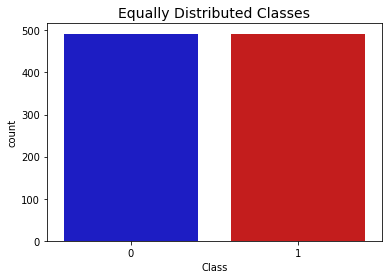

In [71]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class', data=new_df, palette = colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

### Correlation Matrices

 #### Summary and Explanation:

 - **Negative Correlations:** V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.
 - **Positive Correlations:** V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.
 - **BoxPlots:** We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions.

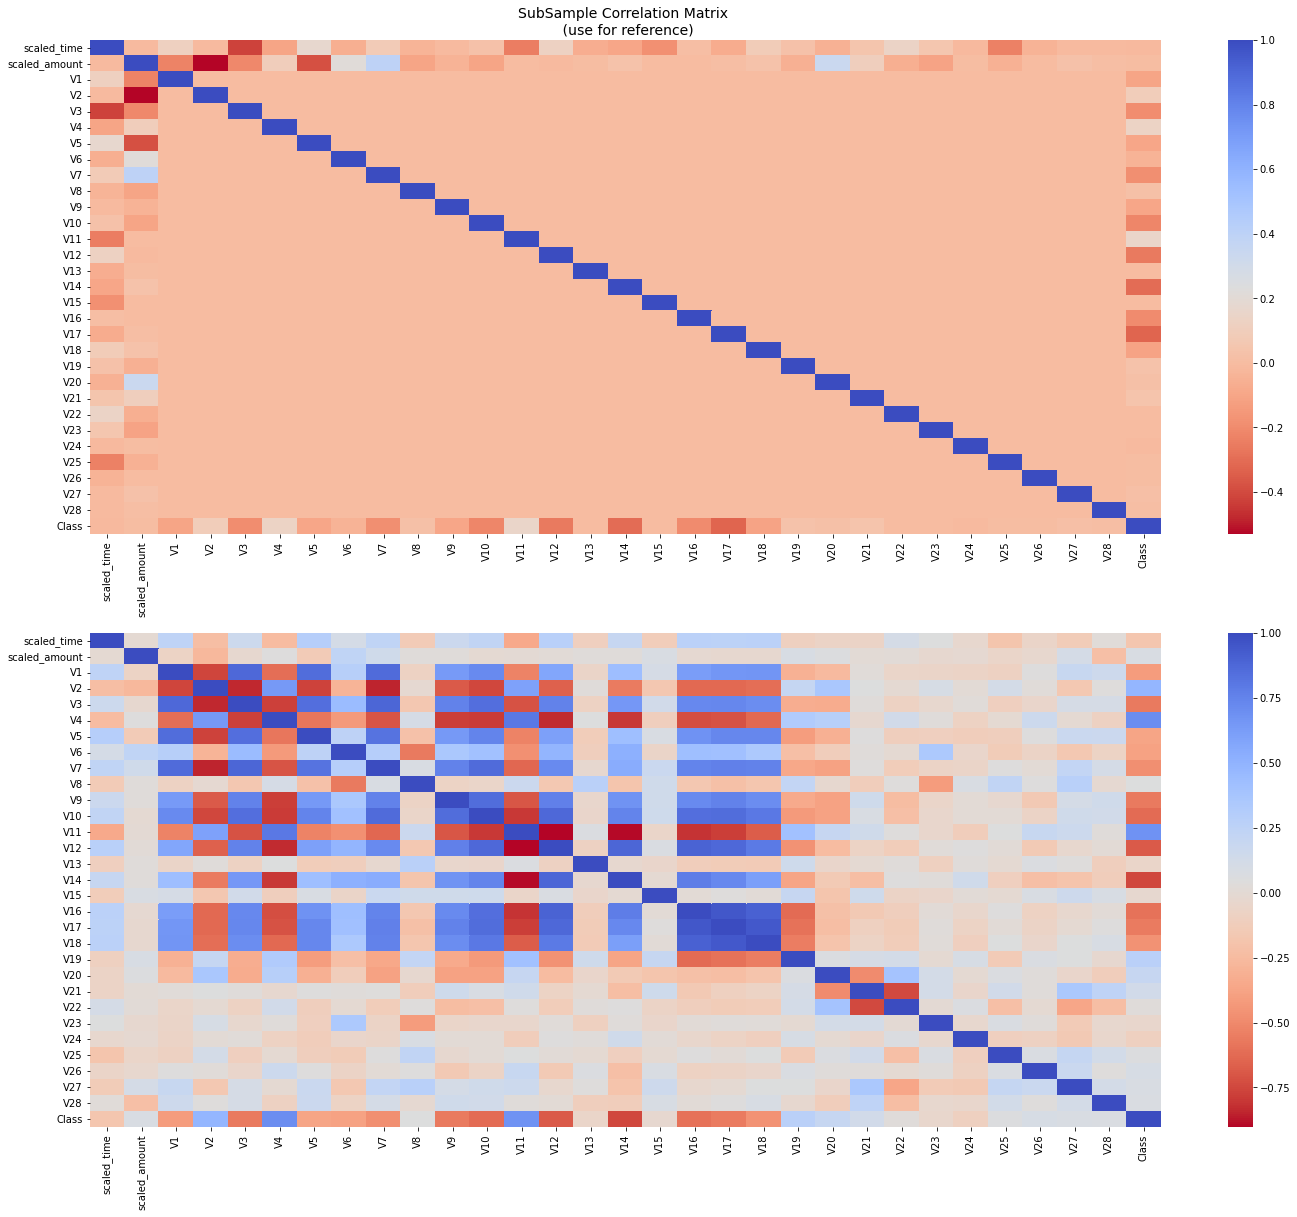

In [72]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire Dataframe
corr = df.corr()
sns.heatmap(corr, cmap = 'coolwarm_r', annot_kws = {'size':20}, ax = ax1)
ax1.set_title("Imblanced Correlation Matrix \n (dont use for reference)", fontsize=14)

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap = 'coolwarm_r', annot_kws = {'size':20}, ax = ax2)
ax1.set_title("SubSample Correlation Matrix \n (use for reference)", fontsize=14)
plt.show()

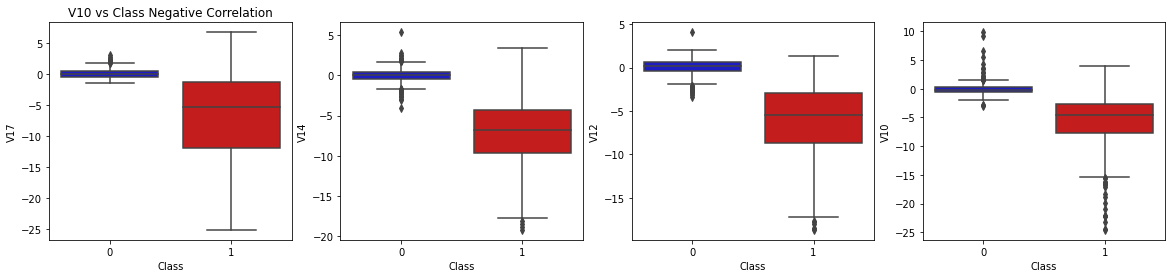

In [73]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative correlations with our Class 
sns.boxplot(x='Class', y = 'V17', data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x='Class', y = 'V14', data=new_df, palette=colors, ax=axes[1])
axes[0].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x='Class', y = 'V12', data=new_df, palette=colors, ax=axes[2])
axes[0].set_title('V12 vs Class Negative Correlation')

sns.boxplot(x='Class', y = 'V10', data=new_df, palette=colors, ax=axes[3])
axes[0].set_title('V10 vs Class Negative Correlation')

plt.show()

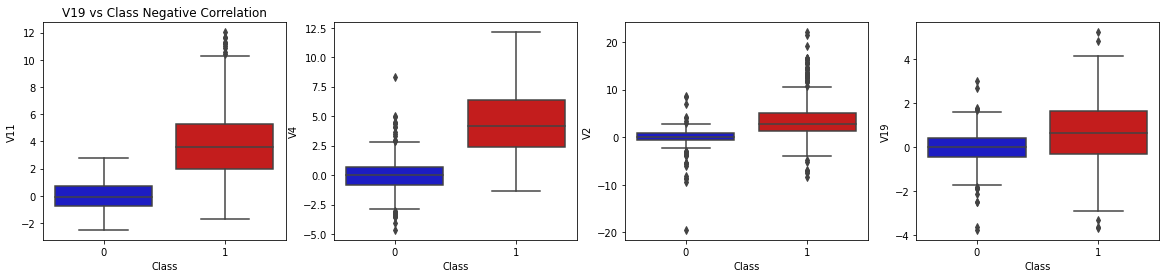

In [74]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations with our Class 
sns.boxplot(x='Class', y = 'V11', data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Negative Correlation')

sns.boxplot(x='Class', y = 'V4', data=new_df, palette=colors, ax=axes[1])
axes[0].set_title('V4 vs Class Negative Correlation')

sns.boxplot(x='Class', y = 'V2', data=new_df, palette=colors, ax=axes[2])
axes[0].set_title('V2 vs Class Negative Correlation')

sns.boxplot(x='Class', y = 'V19', data=new_df, palette=colors, ax=axes[3])
axes[0].set_title('V19 vs Class Negative Correlation')

plt.show()

### Anomaly Detection:

Objective is to remove "extreme outliers" from features having high correlation with our classes, this will improve accuracy of our models.  

#### Interquartile Range Method:

- **InterQuartile Range (IQR):** We calculate this by the difference between the 75th percentile and 25th percentile. Our aim is to create a threshold beyond the 75th and 25th percentile that in case some instance pass this threshold the instance will be deleted. 
- **Boxplots:** Besides easily seeing the 25th and 75th percentile (both end of the squares) it is also easy to see extreme outliers (points beyond the lower and higher extreme). 

#### Outlier Removal TradeOff:

outlier = 25th or 75th percentile + multiplier * IQR
We will focus on removing extreme outliers so as to minimize information loss which can cause decrease in accuracy.

#### Summary:

- **Visualize Distributions:** Visualize feature distributions to help eliminate outliers. V14 is the only feature with a Gaussian distribution compared to V12 and V10.
- **Determining the threshold:** After deciding the multiplier to be multiplied with IQR, we will decide upper and lower thresholds
- **Conditional Dropping:** Lastly we create a conditional dropping stating that if "threshold" is exceeded in both extremes, the instance will be removed.
- **Boxplot Representation:** Visualize to check the number of "extreme outliers" have been reduced to a considerable amount.

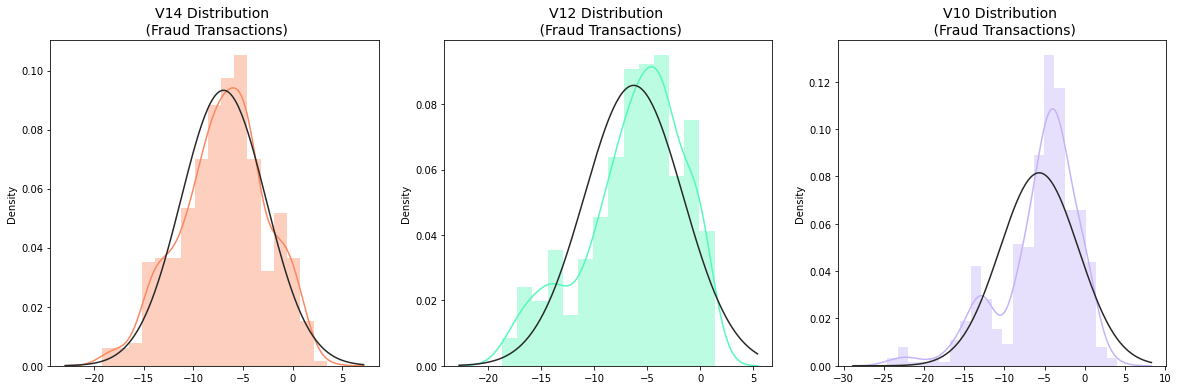

In [75]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist, ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [76]:
# Removing Outliers for V14 column (this column has highest negative correlation with labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for fraud Cases: {}'.format(len(outliers)))
print('V14 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# Removing Outliers for V12 column 
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25
v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 Outliers: {}'.format(outliers))
print('Feature V12 outliers for fraud cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of instances after outlier removal: {}'.format(len(new_df)))
print('----' * 44)

# Removing Outliers for V10 column 
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25
v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 Outliers: {}'.format(outliers))
print('Feature V10 outliers for fraud cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of instances after outlier removal: {}'.format(len(new_df)))
print('----' * 44)

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for fraud Cases: 4
V14 outliers:[-19.2143254902614, -18.8220867423816, -18.4937733551053, -18.0499976898594]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 Outliers: [-18.4311310279993, -18.6837146333443, -18.0475965708216, -18.5536970096458]
Feature V12 outliers for fraud cases: 4
Number of instances after outlier removal: 975
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 Outliers: [-15.5637913387301, -16.3035376

### Dimensionality Reduction and Clustering

### Understanding t-SNE:

For understanding this algorithm: understand these terms: **Euclidean distance**, **Conditional Probability**, **Normal and T-Distribution Plots**.

Reference: https://www.youtube.com/watch?v=NEaUSP4YerM

### Summary

- t-SNE algorithm can pretty accurately cluster the fraud and non-fraud cases in our dataset.
- t-SNE algorithm is able to accurately detect clusters even with small sub sample.
- This gives us an indication that further predictive models will perform pretty well in separating fraud cases from non-fraud cases.

In [77]:
# new_df is from the random undersampling data
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD Implementation
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm="randomized", random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 2.3e+01 s
PCA took 0.015 s
Truncated SVD took 0.005 s


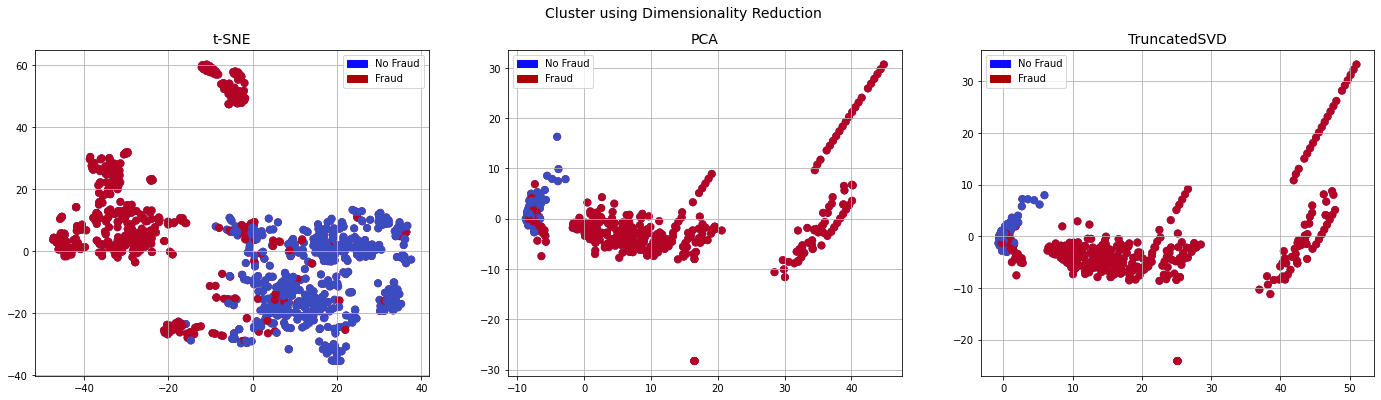

In [78]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(24,6))
f.suptitle("Cluster using Dimensionality Reduction", fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label= 'No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label= 'Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA Scatter Plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y==0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y==1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y==0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y==1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('TruncatedSVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

### Classifiers (under sampling):

#### Summary:
- Logistic Regression classifier is more accurate than other three classifiers
- GridSearchCV is used to determine the parameters that gives the best predictive score for the classifiers.
- Logistic Regression has the best Receiving Operating Characteristics score (ROC score), meaning LogisticRegression pretty accurately separates fraud and non-fraud transactions.

#### Learning Curves:
- The wider the gap between the training score and the cross validation score, the more likely your model is **overfitting (high variance).**
- If the score is low in both training and cross-validation sets this is an indication that our model is **underfitting (high bias)**
- **Logistic Regression Classifier** shows the best score in both training and cross-validation sets.

In [79]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# data already scaled, so we should split our training and test sets
from sklearn.model_selection import train_test_split

# this is explicitely used for under sampling
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(),
    'KNearest': KNeighborsClassifier(),
    'Support Vector Classifier': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print('Classifiers: ', classifier.__class__.__name__, 'Has a training score of', round(training_score.mean(),2)*100, '% accuracy score')

Classifiers:  LogisticRegression Has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 91.0 % accuracy score


In [80]:
# Use GridSearchCV for the best parameters
from sklearn.model_selection import GridSearchCV

# Logistic Regression
log_reg_params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

# Logistic Regression best estimator
log_reg = grid_log_reg.best_estimator_

# K Nearest Neighbors
knears_params = {'n_neighbors': list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)

# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly','sigmoid','linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# Decision Tree Classifier
tree_params = {'criterion':['gini', 'entropy'], 'max_depth':list(range(2,4,1)), 'min_samples_leaf': list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# Tree best estimator
tree_clf = grid_tree.best_estimator_

In [81]:
# Overfitting case
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean()*100, 2).astype('str') + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('KNears Neighbors Cross Validation Score: ', round(knears_score.mean()*100, 2).astype('str') + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score: ', round(svc_score.mean()*100, 2).astype('str') + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('Decision Tree Classifier Cross Validation Score: ', round(tree_score.mean()*100, 2).astype('str') + '%')

Logistic Regression Cross Validation Score:  94.7%
KNears Neighbors Cross Validation Score:  92.58%
Support Vector Classifier Cross Validation Score:  94.04%
Decision Tree Classifier Cross Validation Score:  92.72%


In [82]:
# We will undersample during cross validation
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print('Train:', train_index, 'Test:', test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique

# Distribution of NearMiss 
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

Train: [ 52687  53663  54781 ... 284804 284805 284806] Test: [    0     1     2 ... 56965 56966 56967]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 52687  53663  54781 ... 115572 117633 117826]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113916 113917 113918 ... 173648 174545 174652]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170878 170879 170880 ... 227844 227845 227846]
Train: [     0      1      2 ... 227844 227845 227846] Test: [227707 227847 227848 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [83]:
# Cross-validating the right way
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during cross validation, not before
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction)) 

In [84]:
# Lets plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None, n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,14), sharey=True)
  if ylim is not None:
    plt.ylim(*ylim)
  # First estimator
  train_sizes, train_scores, test_scores = learning_curve(estimator1, X, y, cv=cv, n_jobs = n_jobs, train_sizes = train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  ax1.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='#ff9124')
  ax1.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='#2492ff')
  ax1.plot(train_sizes, train_scores_mean, 'o-', color='#ff9124', label='Training Score')
  ax1.plot(train_sizes, test_scores_mean, 'o-', color='#2492ff', label = 'Cross-validation score')
  ax1.set_title('Logistic Regression Learning Curve', fontsize=14)
  ax1.set_xlabel('Training Size (m)')
  ax1.set_ylabel('Score')
  ax1.grid(True)
  ax1.legend(loc='best')

  # Second estimator
  train_sizes, train_scores, test_scores = learning_curve(estimator2, X, y, cv=cv, n_jobs = n_jobs, train_sizes = train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  ax2.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='#ff9124')
  ax2.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='#2492ff')
  ax2.plot(train_sizes, train_scores_mean, 'o-', color='#ff9124', label='Training Score')
  ax2.plot(train_sizes, test_scores_mean, 'o-', color='#2492ff', label = 'Cross-validation score')
  ax2.set_title('KNears Neighbors Learning Curve', fontsize=14)
  ax2.set_xlabel('Training Size (m)')
  ax2.set_ylabel('Score')
  ax2.grid(True)
  ax2.legend(loc='best')

  # Third estimator
  train_sizes, train_scores, test_scores = learning_curve(estimator3, X, y, cv=cv, n_jobs = n_jobs, train_sizes = train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  ax3.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='#2492ff')
  ax3.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='#ff9124')
  ax3.plot(train_sizes, train_scores_mean, 'o-', color='#ff9124', label='Training Score')
  ax3.plot(train_sizes, test_scores_mean, 'o-', color='#2492ff', label = 'Cross-validation score')
  ax3.set_title('Support Vector Classifier \n Learning Curve', fontsize=14)
  ax3.set_xlabel('Training Size (m)')
  ax3.set_ylabel('Score')
  ax3.grid(True)
  ax3.legend(loc='best')

  # Forth Estimator
  train_sizes, train_scores, test_scores = learning_curve(estimator4, X, y, cv=cv, n_jobs = n_jobs, train_sizes = train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  ax4.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='#2492ff')
  ax4.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='#ff9124')
  ax4.plot(train_sizes, train_scores_mean, 'o-', color='#ff9124', label='Training Score')
  ax4.plot(train_sizes, test_scores_mean, 'o-', color='#2492ff', label = 'Cross-validation score')
  ax4.set_title('Decision Tree Classifier \n Learning Curve', fontsize=14)
  ax4.set_xlabel('Training Size (m)')
  ax4.set_ylabel('Score')
  ax4.grid(True)
  ax4.legend(loc='best')
  return plt

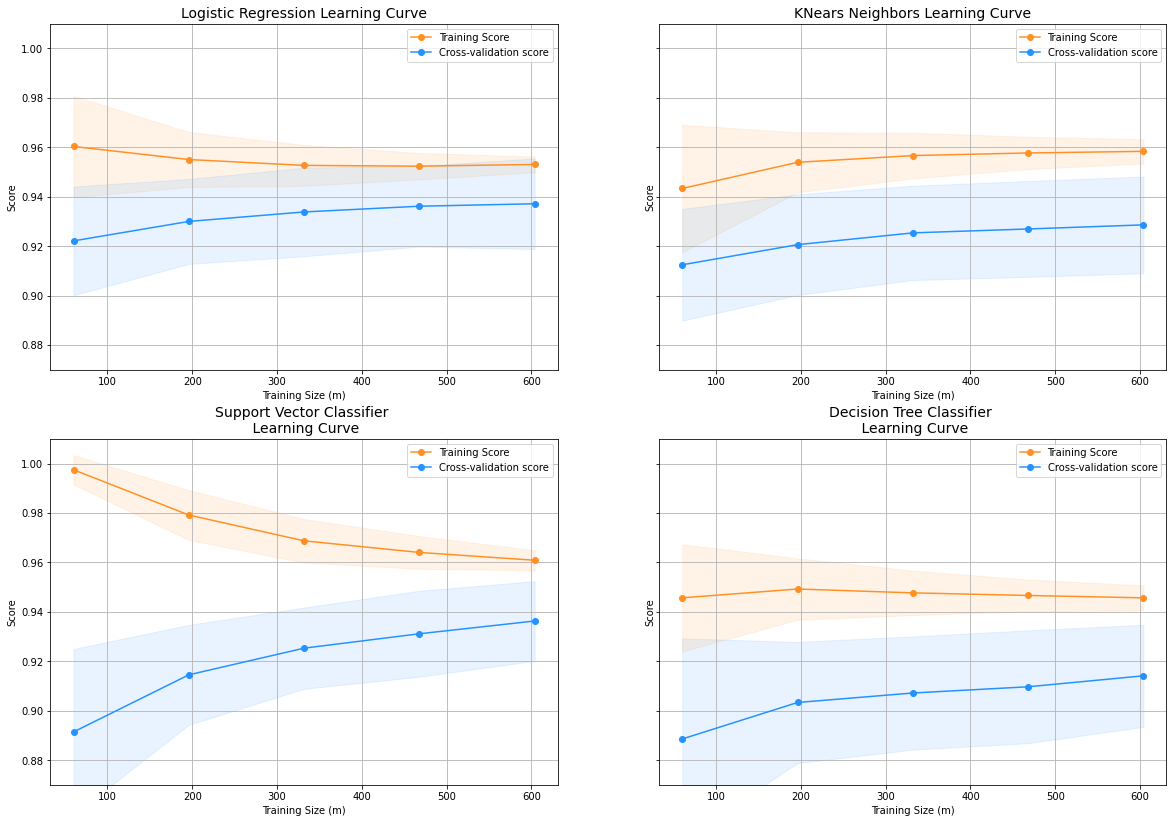

In [85]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4);

In [86]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

# Creating dataframe with all the scores and the classifier names
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method='decision_function')

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method='decision_function')

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [87]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier', roc_auc_score(y_train, tree_pred))

Logistic Regression 0.981661681901793
KNears Neighbors 0.9249547158684022
Support Vector Classifier 0.9783408455846216
Decision Tree Classifier 0.9261306991308255


In [88]:
log_fpr, log_tpr, log_threshold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
  plt.figure(figsize=(16,8))
  plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
  plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
  plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
  plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
  plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
  plt.plot([0,1],[0,1], 'k--')
  plt.axis([-0.01, 1, 0, 1])
  plt.xlabel('False Positive Rate', fontsize=16)
  plt.ylabel('True Positive Rate', fontsize=16)
  plt.annotate('Minimum ROC curve of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext = (0.6, 0.3), arrowprops=dict(facecolor='#6E726D', shrink=0.05))
  plt.legend()

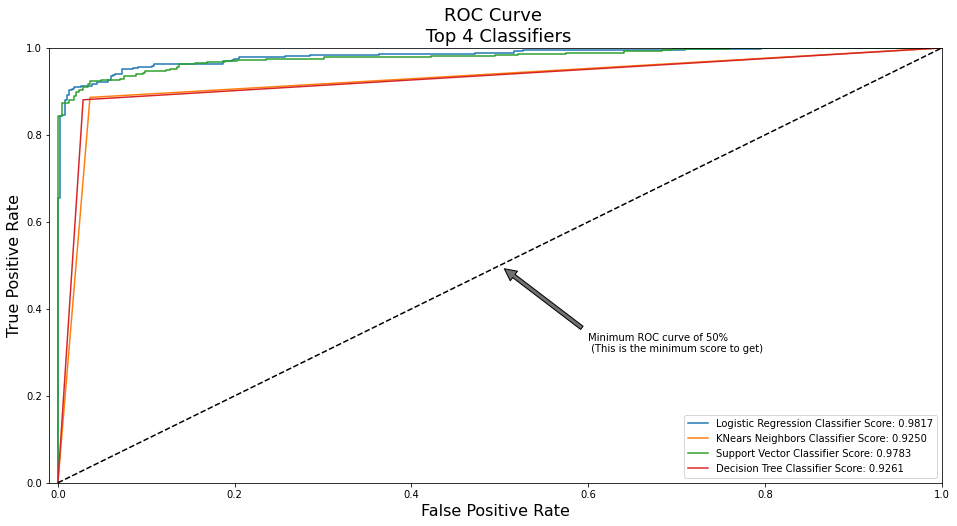

In [89]:
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

### A Deeper look into Logistic Regression

Terms:

- **True positives:** Correctly classified fraud transactions
- **False positives:** Incorrectly classifed fraud transactions
- **True Negative:** Correctly classified non-fraud transactions
- **False Negative:** Incorrectly classified non-fraud transactions
- **Precision:** True positives / (True positives + False positives)
- **Recall:** True positives / (True positives + false negatives)

Precision is how precise (how sure) is our model in detecting fraud transactions while recall is the amount of fraud cases our model is able to detect.

Precision/Recall Tradeoff: The more precise (selective) our model is, the less cases it will detect. 

Precision starts to descend between 0.9 and 0.92, still this precision score is high and we still have a descent recall score.

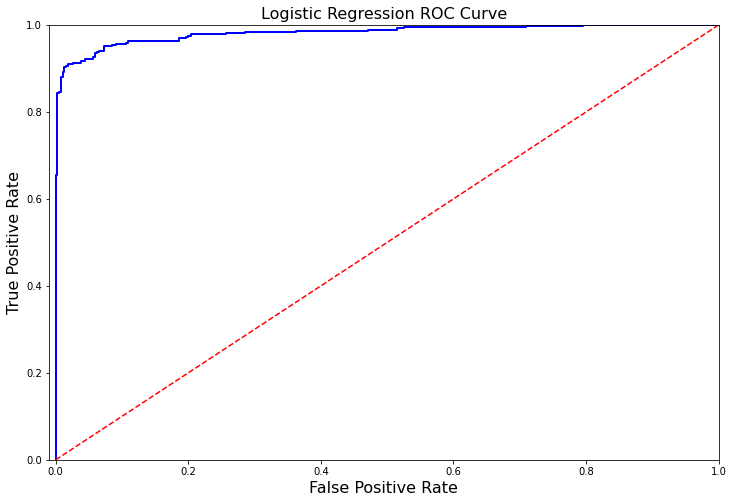

In [90]:
def logistic_roc_curve(log_fpr, log_tpr):
  plt.figure(figsize=(12,8))
  plt.title('Logistic Regression ROC Curve', fontsize=16)
  plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
  plt.plot([0,1], [0,1], 'r--')
  plt.xlabel('False Positive Rate', fontsize=16)
  plt.ylabel('True Positive Rate', fontsize=16)
  plt.axis([-0.01, 1,0,1])

logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [91]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

y_pred = log_reg.predict(X_train)

# Overfitting case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be: \n')
print('Accuracy Score: {:.2f}'.format(np.mean(undersample_accuracy)))
print('Precision Score: {:.2f}'.format(np.mean(undersample_precision)))
print('Recall Score: {:.2f}'.format(np.mean(undersample_recall)))
print('F1 Score: {:.2f}'.format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.91
Precision Score: 0.86
F1 Score: 0.88
Accuracy Score: 0.88
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be: 

Accuracy Score: 0.88
Precision Score: 0.00
Recall Score: 0.10
F1 Score: 0.00
---------------------------------------------------------------------------------------------------------------------------------------


In [92]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [93]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(undersample_average_precision))

Average precision-recall score: 0.07


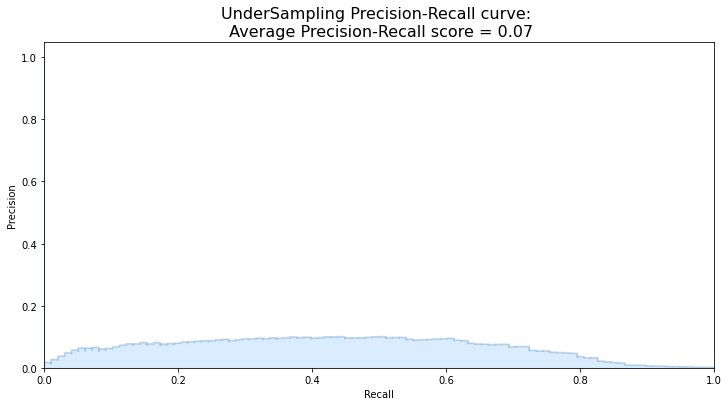

In [94]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall , _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2, where='post')

plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall score = {0:0.2f}'.format(undersample_average_precision), fontsize=16);

### SMOTE Technique 

Synthetic Minority Over Sampling Technique. Unlike Random UnderSampling, SMOTE creates new synthetic points for class balancing. This is another alternative to solve the "class imbalance" problems.

**Understanding SMOTE:**

- **Solving the class imbalance:** SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.

- **Location of the synthetic points:** SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.

- **Final Effect:** More information is retained since we didn't have to delete any rows unlike in random undersampling.

- **Accuracy||Time Tradeoff:** Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.

In [97]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

print('Length of X (train): {} | Lenth of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
log_reg_sm = LogisticRegression()

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

# Implementing the SMOTE technique
# Cross validating the right way
# Parameters
log_reg_params = {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
  pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before
  model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
  best_est = rand_log_reg.best_estimator_
  prediction = best_est.predict(original_Xtrain[test])

  accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
  precision_lst.append(precision_score(original_ytrain[test], prediction))
  recall_lst.append(recall_score(original_ytrain[test], prediction))
  f1_lst.append(f1_score(original_ytrain[test], prediction))
  auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print('---' * 45)
print('')
print('accuracy: {}'.format(np.mean(accuracy_lst)))
print('precision: {}'.format(np.mean(precision_lst)))
print('recall: {}'.format(np.mean(recall_lst)))
print('f1: {}'.format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227846 | Lenth of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9703222294907462
precision: 0.06380046115020828
recall: 0.9112301200908796
f1: 0.11818626562028545
---------------------------------------------------------------------------------------------------------------------------------------


In [98]:
labels = ['No Fraud', 'Fraud']

smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.10      0.86      0.17        98

    accuracy                           0.99     56961
   macro avg       0.55      0.92      0.58     56961
weighted avg       1.00      0.99      0.99     56961



In [99]:
y_score = best_est.decision_function(original_Xtest)

In [100]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precison-recall score: {0:0.2f}'.format(average_precision))

Average precison-recall score: 0.70


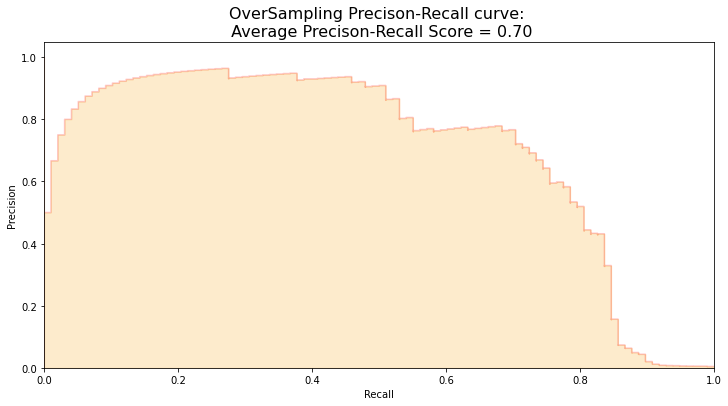

In [101]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2, where='post')

plt.fill_between(recall, precision, step='post', alpha=0.2, color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precison-Recall curve: \n Average Precison-Recall Score = {0:0.2f}'.format(average_precision), fontsize=16);

In [102]:
# SMOTE technique (OverSampling) after splitting and cross-validating
sm = SMOTE(sampling_strategy='minority', random_state=42)

Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print('Fitting oversample data took: {} sec'.format(t1 - t0))

Fitting oversample data took: 9.447944402694702 sec


### Test Data with Logistic Regression

#### Confusion Matrix

- **Positive/Negative:** type of class (label) ['No','Yes'], **True/False:** Correctly or incorrectly classified by the model.
- **True Negatives (Top-Left Square):** This is the number of **correct** classifications of the "No" (No Fraud Detected) class.
- **False Negatives (top-Right Square):** This is the number of **incorrect** classifications of the "No" (No Fraud Detected) class. 
- **False Positives (Bottom-Left Square):** This is the number of **incorrect** classifications of the "Yes" (Fraud Detected) class.
- **True Positives (Bottom-Right Square):** This is the number of **correct** classifications of the "Yes" (Fraud Detected) class.

#### Summary:
- **Random UnderSampling:** We will evaluate the final performance of the classification models in the random undersampling subset (which is different from the original dataset).
- **Classification models:** The models that performed the best were logistic regression and support vector classifier. 

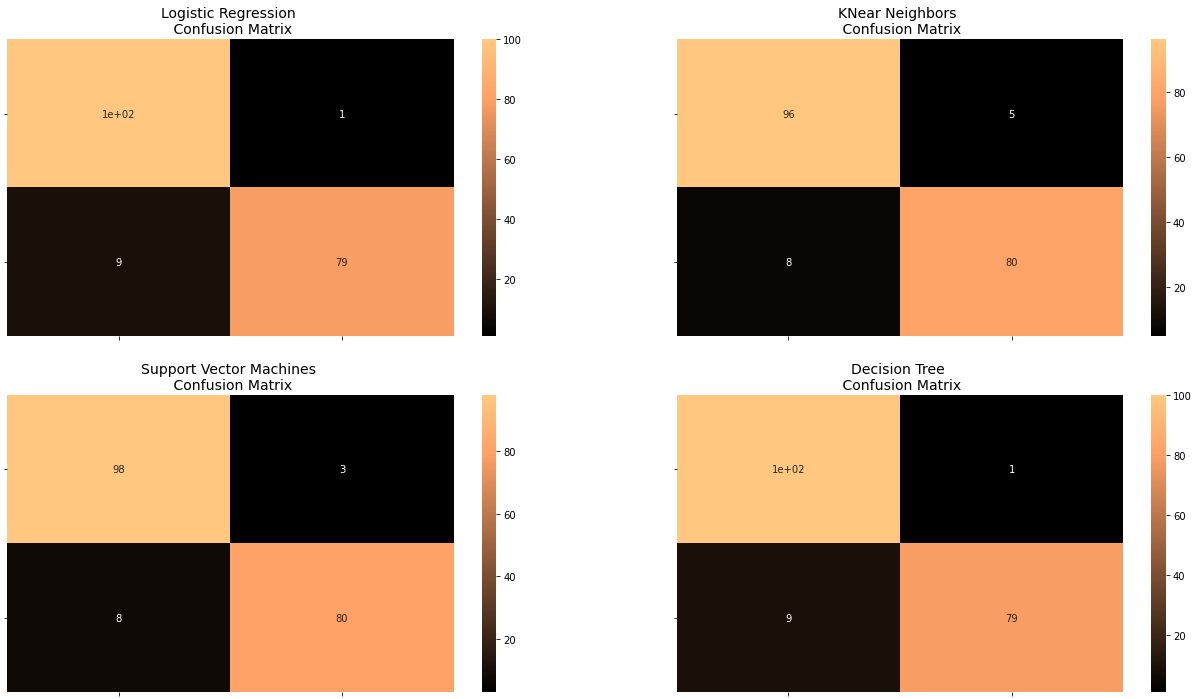

In [104]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2, figsize=(22,12))

sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap = plt.cm.copper)
ax[0,0].set_title('Logistic Regression \n Confusion Matrix', fontsize=14)
ax[0,0].set_xticklabels(['',''], fontsize=14, rotation=90)
ax[0,0].set_yticklabels(['',''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap = plt.cm.copper)
ax[0,1].set_title('KNear Neighbors \n Confusion Matrix', fontsize=14)
ax[0,1].set_xticklabels(['',''], fontsize=14, rotation=90)
ax[0,1].set_yticklabels(['',''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap = plt.cm.copper)
ax[1,0].set_title('Support Vector Machines \n Confusion Matrix', fontsize=14)
ax[1,0].set_xticklabels(['',''], fontsize=14, rotation=90)
ax[1,0].set_yticklabels(['',''], fontsize=14, rotation=360)

sns.heatmap(log_reg_cf, ax=ax[1][1], annot=True, cmap = plt.cm.copper)
ax[1,1].set_title('Decision Tree \n Confusion Matrix', fontsize=14)
ax[1,1].set_xticklabels(['',''], fontsize=14, rotation=90)
ax[1,1].set_yticklabels(['',''], fontsize=14, rotation=360)
plt.show()


In [105]:
from sklearn.metrics import classification_report

print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Suppport Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Decision Tree Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       101
           1       0.99      0.90      0.94        88

    accuracy                           0.95       189
   macro avg       0.95      0.94      0.95       189
weighted avg       0.95      0.95      0.95       189

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       101
           1       0.94      0.91      0.92        88

    accuracy                           0.93       189
   macro avg       0.93      0.93      0.93       189
weighted avg       0.93      0.93      0.93       189

Suppport Vector Classifier:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       101
           1       0.96      0.91      0.94        88

    accuracy                           0.94       189
   macro avg       0.94      0.94      0.94       189
weighte

In [108]:
# Final score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# Logistic Regression with SMOTE Technique 
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

final_df

,Technique,Score
0,Random UnderSampling,0.947090
1,Oversampling (SMOTE),0.985815


### Neural Networks Testing Random UnderSampling Data vs OverSampling (SMOTE):

In this section we will implement a simple Neural Network  (with one hidden layer) in order to see which one of the two logistic regression models we implemented in the (undersample or oversample (SMOTE)) has a better accuracy for detecting fraud and non-fraud transactions. 

#### Summary (Keras || Random UnderSampling):

- **Dataset:** In this final phase of testing we will fit this model in both the **random undersampled subset** and **oversampled subset (SMOTE)** in order to predict the final result using the original testing data. 
- **Neural Network Structure:** As stated previously, this will be a simple model composed of one input layer (number of nodes equals the number of features) plus bias node, one hidden layer with 32 nodes and one output node composed of two possible results 0 or 1 (No fraud or fraud).
- **Other characteristics:** The learning rate will be 0.001, the optimizer we will use is the Adam Optimizer, the activation function that is used in this scenario is "Relu" and for the final outputs we will use sparse categorical cross entropy, which gives the probability whether an instance case is fraud or no fraud (the prediction will pick the highest probability between the two).  

In [111]:
import keras
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
                                Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
                                Dense(32, activation='relu'),
                                Dense(2, activation='softmax')
])

In [112]:
undersample_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 32)                992       
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [113]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs = 20, shuffle=True, verbose=2)

Epoch 1/20
25/25 - 1s - loss: 0.5387 - accuracy: 0.6904 - val_loss: 0.4162 - val_accuracy: 0.8477 - 1s/epoch - 49ms/step
Epoch 2/20
25/25 - 0s - loss: 0.3121 - accuracy: 0.8709 - val_loss: 0.2983 - val_accuracy: 0.9073 - 126ms/epoch - 5ms/step
Epoch 3/20
25/25 - 0s - loss: 0.2301 - accuracy: 0.9238 - val_loss: 0.2451 - val_accuracy: 0.9272 - 104ms/epoch - 4ms/step
Epoch 4/20
25/25 - 0s - loss: 0.1903 - accuracy: 0.9371 - val_loss: 0.2138 - val_accuracy: 0.9272 - 103ms/epoch - 4ms/step
Epoch 5/20
25/25 - 0s - loss: 0.1624 - accuracy: 0.9454 - val_loss: 0.1923 - val_accuracy: 0.9338 - 110ms/epoch - 4ms/step
Epoch 6/20
25/25 - 0s - loss: 0.1448 - accuracy: 0.9503 - val_loss: 0.1760 - val_accuracy: 0.9338 - 112ms/epoch - 4ms/step
Epoch 7/20
25/25 - 0s - loss: 0.1305 - accuracy: 0.9536 - val_loss: 0.1664 - val_accuracy: 0.9404 - 110ms/epoch - 4ms/step
Epoch 8/20
25/25 - 0s - loss: 0.1218 - accuracy: 0.9536 - val_loss: 0.1675 - val_accuracy: 0.9404 - 102ms/epoch - 4ms/step
Epoch 9/20
25/25 -

In [115]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

undersample_fraud_predictions = np.argmax(undersample_model.predict(original_Xtest, batch_size=200, verbose=0), axis=-1)

In [117]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  ''' This function prints and plots the confusion matrix. Normalization can be applied by setting 'normalize=True' '''
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized Confusion Matrix')
  else:
    print('Confusion matrix, without normalization')
  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title, fontsize=14)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i,j], fmt),
             horizontalalignment='center',
             color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion matrix, without normalization
[[54756  2107]
 [    6    92]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


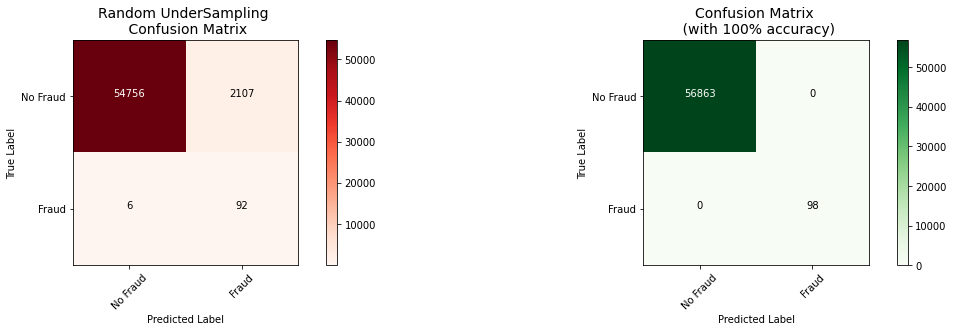

In [119]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSampling \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [120]:
### Keras || OverSampling (SMOTE):

n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
                               Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
                               Dense(32, activation='relu'),
                               Dense(2, activation='softmax')
])

oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
1214/1214 - 5s - loss: 0.0680 - accuracy: 0.9770 - val_loss: 0.0261 - val_accuracy: 0.9942 - 5s/epoch - 4ms/step
Epoch 2/20
1214/1214 - 3s - loss: 0.0153 - accuracy: 0.9963 - val_loss: 0.0078 - val_accuracy: 0.9998 - 3s/epoch - 3ms/step
Epoch 3/20
1214/1214 - 3s - loss: 0.0083 - accuracy: 0.9983 - val_loss: 0.0109 - val_accuracy: 0.9986 - 3s/epoch - 3ms/step
Epoch 4/20
1214/1214 - 4s - loss: 0.0057 - accuracy: 0.9988 - val_loss: 0.0028 - val_accuracy: 1.0000 - 4s/epoch - 3ms/step
Epoch 5/20
1214/1214 - 4s - loss: 0.0044 - accuracy: 0.9992 - val_loss: 0.0027 - val_accuracy: 0.9998 - 4s/epoch - 3ms/step
Epoch 6/20
1214/1214 - 2s - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.0023 - val_accuracy: 0.9998 - 2s/epoch - 2ms/step
Epoch 7/20
1214/1214 - 2s - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0014 - val_accuracy: 0.9999 - 2s/epoch - 2ms/step
Epoch 8/20
1214/1214 - 2s - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0025 - val_accuracy: 0.9998 - 2s/epoch - 2ms/step
Epoch 9/

In [121]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

oversample_fraud_predictions = np.argmax(oversample_model.predict(original_Xtest, batch_size=200, verbose=0), axis=-1)

Confusion matrix, without normalization
[[56855     8]
 [   29    69]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


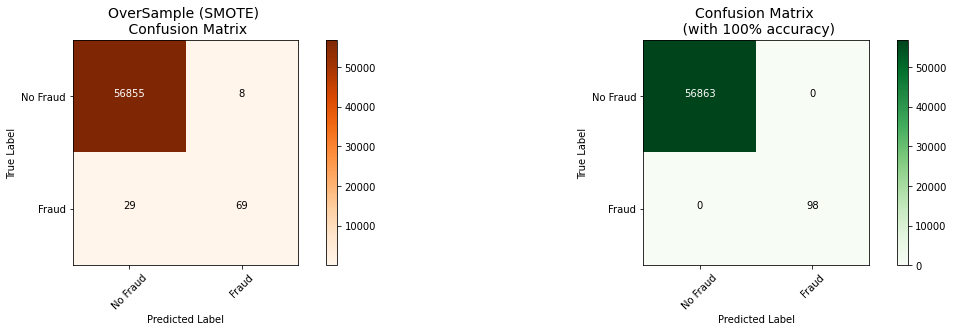

In [124]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels=['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title='OverSample (SMOTE) \n Confusion Matrix', cmap = plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title='Confusion Matrix \n (with 100% accuracy)', cmap = plt.cm.Greens)